In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Simple EDA

Read in the data.

In [2]:
data_train = pd.read_csv('train_data.csv')

Some of the features, like photos and votes, aren't helpful to the model, so they need to be removed.

In [3]:
data_train.drop(columns = 'photos', inplace = True)
data_train.drop(columns = 'Unnamed: 0', inplace = True)
data_train.drop(columns = 'comments', inplace = True)
data_train.drop(columns = 'rating', inplace = True)

I noticed by looking at the residuals (found in a section below) that many of the routes
that my model was predicting incorrectly were routes that had very few votes. Since very few
votes could just mean that the route is new, and consequently heavily influenced by the few
votes, I'm removing the routes with less than three votes. Then I will drop the votes column,
since it won't be needed for further analysis.

In [4]:
#Drop rows that have less than three votes
data_train = data_train[data_train['votes']>3]

#Drop the votes column
data_train.drop(columns = 'votes', inplace = True)

Visualize correlations between every feature using pairplot.

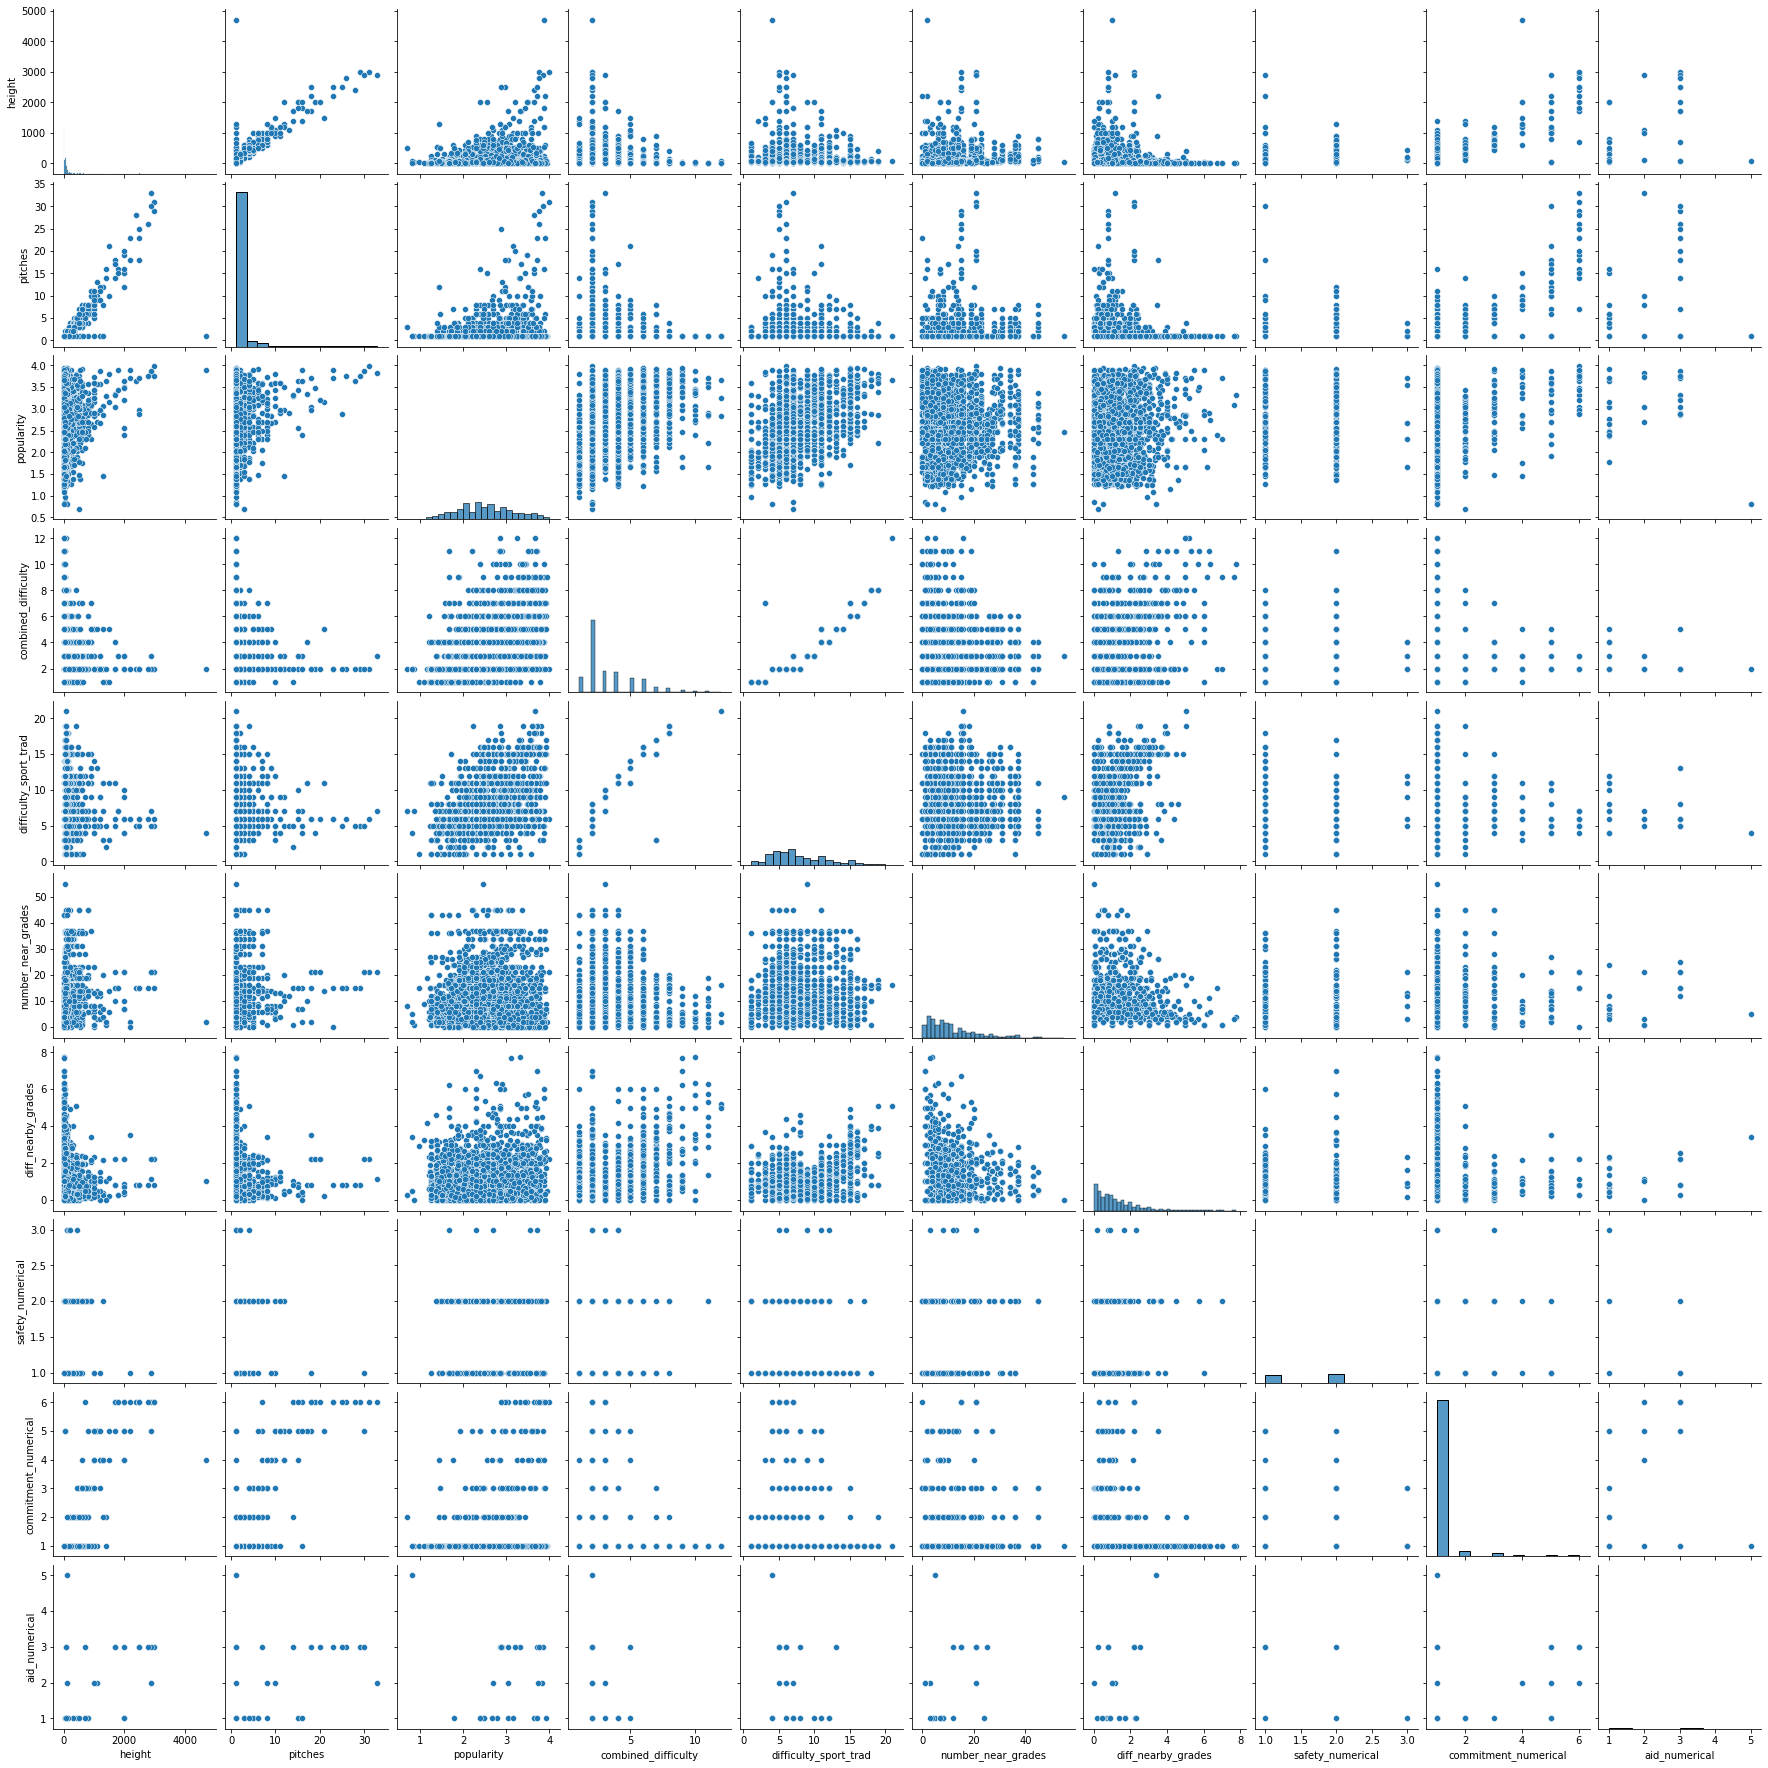

In [5]:
sns.pairplot(data_train)

Based on the skew of the histogram and the scatterplot between height and popularity, it 
looks like I should convert the height feature to a log scale.

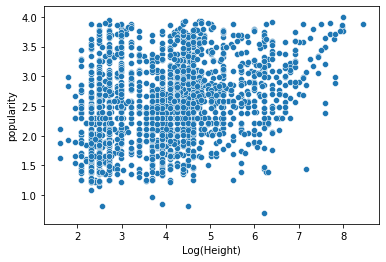

In [6]:
#Convert height to log scale and print the scatterplot
data_train['Log(Height)'] = np.log(data_train['height'])

sns.scatterplot(x='Log(Height)', y='popularity', data=data_train)

Number_near_grades and combined_difficulty also seem skewed. I'll make two new rows
with these values in log format.

In [7]:
#Number_near_grades in log
data_train['Log(number_near_grades)'] = np.log(data_train['number_near_grades'])

#Combined_difficulty in log
data_train['Log(combined_difficulty)'] = np.log(data_train['combined_difficulty'])

/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The diff_nearby_grades is skewed, but it has zero values in it. The zero values must first 
be converted to .000001 (which I read is small enough without having Python round the number
up to zero) before converting the feature to log.

/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


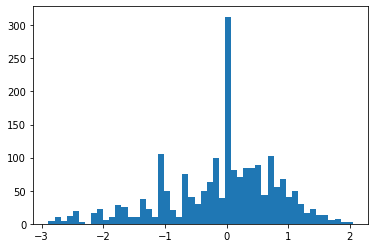

In [8]:
data_train['Log(diff_nearby_grades)'] = np.log(data_train['diff_nearby_grades'])

def inf_to_val(row):
    log_val = row['Log(diff_nearby_grades)']
    if row['Log(diff_nearby_grades)'] <  -1000:
        log_val = 0.000001
    return log_val
        
data_train['Log(diff_nearby_grades)'] = data_train.apply(lambda row: inf_to_val(row), axis=1)


#sns.scatterplot(x='Log(diff_nearby_grades)', y='popularity', data=data_train)
plt.hist(data_train["Log(diff_nearby_grades)"],bins=50);


View general information about data.

In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 4177
Data columns (total 23 columns):
name                        2090 non-null object
grade                       2090 non-null object
type                        2090 non-null object
height                      2090 non-null float64
pitches                     2090 non-null int64
safety                      229 non-null object
commitment                  140 non-null object
state                       2090 non-null object
sub_area                    2090 non-null object
near_grades                 2090 non-null object
aid_grade                   28 non-null object
popularity                  2090 non-null float64
combined_difficulty         2090 non-null int64
difficulty_sport_trad       1364 non-null float64
number_near_grades          2090 non-null int64
diff_nearby_grades          2031 non-null float64
safety_numerical            229 non-null float64
commitment_numerical        2090 non-null int64
aid_numerical  

The safety, commitment, aid_grade, and aid_numerical features only have a few hundred rows
each, so they should be removed.

In [10]:
data_train.drop(columns = 'safety', inplace = True)
data_train.drop(columns = 'commitment', inplace = True)
data_train.drop(columns = 'aid_grade', inplace = True)
data_train.drop(columns = 'aid_numerical', inplace = True)
data_train.drop(columns = 'safety_numerical', inplace = True)

The null rows for diff_nearby_grades should also be removed.

In [11]:
data_train = data_train[data_train['diff_nearby_grades'] > -1]

Visualize correlations between features with a heatmap.

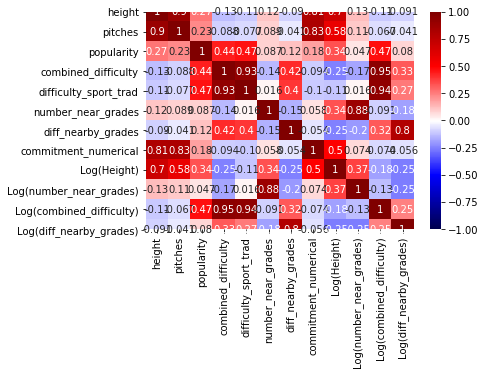

In [12]:
sns.heatmap(data_train.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

It looks like **height** and **pitches** are **strongly correlated**, which makes sense given
their definitions. One pitch is a single length of rope, two pitches is two lengths
of rope, and so on. So it makes sense to remove either height or pitches from my future
model. **I'll remove pitches.**

In [13]:
data_train.drop(columns = 'pitches', inplace = True)

/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**What other relationships seem significant in the heat map?**

Between features:
* Height and commitment
* Difficulty and difficulty_sport_trad (although these won't be used together. Difficulty_sport_trad is a variable to be used only in the case that I separate the data into three separate models for the three main types of climbing.
* Difficulty and the difference between the route's difficulty and the difficulty of nearby grades

Between features and the target (popularity) (over .2 correlation):
* Difficulty
* Height


None of the correlations between features and target are *extremely* significant, but they're
high enough to potentially be used in a model.

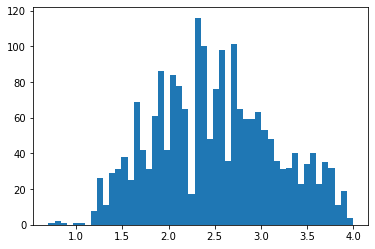

In [14]:
plt.hist(data_train["popularity"],bins=50);


Calculate the Variance Inflation Factor (VIF) of the features to make sure there isn't any collinearity. If two features receive a VIF of more than 5, then one needs to be removed.

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# the independent variables set 
X = data_train[['diff_nearby_grades', 'combined_difficulty', 'number_near_grades', 'Log(Height)']] 
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 

vif_data

,feature,VIF
0,diff_nearby_grades,2.529534
1,combined_difficulty,3.679937
2,number_near_grades,2.854680
3,Log(Height),4.461341


## Simple Baseline Model

In [16]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results.
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # score fit model on validation data
    train_score = lr_model.score(X_train, y_train)
    
    # report results
    print('\nTrain R^2 score was:', train_score)    
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

I'll start off with just four variables that have no nan values and are somewhat correlated 
with the target:

In [17]:
X = data_train[['Log(Height)', 'combined_difficulty','number_near_grades', 'diff_nearby_grades']]
y = data_train['popularity']
split_and_validate(X, y)


Train R^2 score was: 0.40730374859711727

Validation R^2 score was: 0.4090448515115864
Feature coefficient results: 

Log(Height) : 0.25
combined_difficulty : 0.19
number_near_grades : -0.00
diff_nearby_grades : -0.01


In [18]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2031 entries, 0 to 4177
Data columns (total 17 columns):
name                        2031 non-null object
grade                       2031 non-null object
type                        2031 non-null object
height                      2031 non-null float64
state                       2031 non-null object
sub_area                    2031 non-null object
near_grades                 2031 non-null object
popularity                  2031 non-null float64
combined_difficulty         2031 non-null int64
difficulty_sport_trad       1351 non-null float64
number_near_grades          2031 non-null int64
diff_nearby_grades          2031 non-null float64
commitment_numerical        2031 non-null int64
Log(Height)                 2031 non-null float64
Log(number_near_grades)     2031 non-null float64
Log(combined_difficulty)    2031 non-null float64
Log(diff_nearby_grades)     2031 non-null float64
dtypes: float64(8), int64(3), object(6)
memory usage: 2

Now I'll try adding in some categorical data.

## Adding Type Categorical Feature Dummy Variables

In [19]:
#Make a new dataframe called data_train_type where the category type now is a dummy variable.
data_train_type = data_train.copy()
train_category = data_train_type[['type']]

def split_it(row):
    """Standardize type column by removing brackets, spaces, and quotation marks"""
    split_it = row['type'].replace('[', '').replace(']', '').replace("'", '').replace(' ', '')
    return split_it.split(',')

data_train_type['type'] = data_train_type.apply(lambda row: split_it(row), axis=1)

data_train_type = data_train_type.drop('type', 1).join(data_train_type.type.str.join('|').str.get_dummies())
data_train_type.head()

,name,grade,height,state,sub_area,near_grades,popularity,combined_difficulty,difficulty_sport_trad,number_near_grades,...,Log(number_near_grades),Log(combined_difficulty),Log(diff_nearby_grades),Aid,Alpine,Boulder,Snow,Sport,TR,Trad
0,The High Road,V7,25.0,Nevada,Red Spring Boul…,"['V3', 'V7', 'V1', 'V2', 'V9-', 'V7-', 'V5', '...",2.781291,9,NaN,12,...,2.484907,2.197225,0.916291,0,0,1,0,0,0,0
1,White Tigers,5.10b,80.0,Nevada,03-First Pullou…,"['5.10c', '5.9', '5.10a', '5.9']",2.112990,2,8.0,4,...,1.386294,0.693147,-1.386294,0,0,0,0,1,0,0
6,Dolphin Safe,5.7,110.0,Nevada,03-First Pullou…,"['5.8', '5.9', '5.3', '5.5', '5.6', '5.8', '5....",2.493589,2,4.0,12,...,2.484907,0.693147,-1.098612,0,0,0,0,1,0,1
11,The Thumb Aid Climb,5.10c,35.0,California,Mission Gorge,"['5.12-', '5.6', '5.12a', '5.11c', '5.8', '5.9...",2.458971,3,9.0,55,...,4.007333,1.098612,0.000001,1,0,0,0,0,0,0
14,Crab On A Slab,5.8,50.0,Nevada,03-First Pullou…,"['5.6', '5.7', '5.7', '5.5', '5.5', '5.7', '5....",2.397158,2,5.0,14,...,2.639057,0.693147,-1.029619,0,0,0,0,1,0,0


In [20]:
X = data_train_type[['combined_difficulty', 'number_near_grades', 
          'Log(Height)', 'diff_nearby_grades', 'Aid', 'Alpine', 'Boulder',
          'Snow', 'Sport', 'TR', 'Trad']]
y = data_train_type['popularity']

split_and_validate(X, y)


Train R^2 score was: 0.41432177216184995

Validation R^2 score was: 0.41218792440208074
Feature coefficient results: 

combined_difficulty : 0.19
number_near_grades : 0.00
Log(Height) : 0.23
diff_nearby_grades : -0.02
Aid : 0.14
Alpine : 0.13
Boulder : -0.02
Snow : -0.36
Sport : -0.06
TR : -0.15
Trad : 0.02


## Finding and plotting residuals

In [21]:
m = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(data_train_type[['combined_difficulty', 
        'number_near_grades', 'Log(Height)', 'Aid', 'Alpine', 'Boulder',
        'Snow', 'Sport', 'TR', 'Trad']], data_train_type['popularity'], test_size=0.33, random_state=42)
m.fit(X_train,y_train)

data_train_type['res'] = m.predict(data_train_type[['combined_difficulty', 
        'number_near_grades', 'Log(Height)', 'Aid', 'Alpine', 'Boulder',
        'Snow', 'Sport', 'TR', 'Trad']]) - data_train_type['popularity']

data_train_type.sort_values(['res']).head()

,name,grade,height,state,sub_area,near_grades,popularity,combined_difficulty,difficulty_sport_trad,number_near_grades,...,Log(combined_difficulty),Log(diff_nearby_grades),Aid,Alpine,Boulder,Snow,Sport,TR,Trad,res
3529,Trophy Crack,5.10-,12.0,Nevada,Sandstone Quarr…,['V0-1'],3.756408,2,7.0,1,...,0.693147,0.000001,0,0,1,0,0,0,0,-1.842696
1364,The Church of the Lost and Found (Right),V1,10.0,California,Catacombs,"['V3', 'V2', 'V0']",3.566535,3,NaN,3,...,1.098612,-0.405465,0,0,1,0,0,0,0,-1.518791
64,Betty Jo Yablonksi,5.10a,25.0,California,Entrance Boulde…,['V0'],3.573364,2,7.0,1,...,0.693147,0.000001,0,0,1,0,0,0,0,-1.484597
1165,Natasha's Highball,V2,20.0,Nevada,Black Velvet Ca…,['V4'],3.860850,4,NaN,1,...,1.386294,0.693147,0,0,1,0,0,0,0,-1.471120
3781,Circuit Breaker,5.11b,20.0,California,Curry Village,"['5.12b', 'V5', 'V2']",3.687565,4,12.0,3,...,1.386294,0.510826,0,0,1,0,0,1,0,-1.418826


In [22]:
data_train_type.sort_values(['res']).tail()

,name,grade,height,state,sub_area,near_grades,popularity,combined_difficulty,difficulty_sport_trad,number_near_grades,...,Log(combined_difficulty),Log(diff_nearby_grades),Aid,Alpine,Boulder,Snow,Sport,TR,Trad,res
2762,No Hope,V7,14.0,California,No Hope / Big B…,"['V-easy', 'V3', 'V1', 'V0', 'V1']",1.658971,9,NaN,5,...,2.197225,1.824549,0,0,1,0,0,0,0,1.532001
1029,Centerfold,5.10a,1300.0,Nevada,Mescalito,"['5.9', '5.10+', '5.8', '5.7', '5.8-', '5.9', ...",1.442122,2,7.0,20,...,0.693147,-1.049822,0,0,0,0,0,0,1,1.628364
1576,Chouca,5.7+,90.0,California,Wedge,"['5.12a', '5.12+', '5.13-', '5.10d', '5.10c']",0.811857,2,4.0,5,...,0.693147,1.223775,1,0,0,0,1,0,0,1.674607
1487,Poison Control,V9,15.0,Nevada,W Cluster,"['V1', 'V3', 'V8-9', 'V6']",1.658971,11,NaN,4,...,2.397895,1.504077,0,0,1,0,0,0,0,1.902427
1306,Old Married Couple,5.10-,500.0,California,4:20 Wall,"['5.10c', '5.8', '5.10d', '5.9', '5.9', '5.10a...",0.698971,2,7.0,8,...,0.693147,-1.386294,0,0,0,0,0,0,1,2.141069


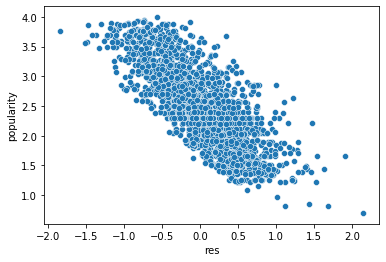

In [23]:
sns.scatterplot(x='res', y='popularity', data=data_train_type)

Looking at the residuals, there are some boulders with sport grades. Those should be removed.

In [24]:
def remove_wrong_grade(row):
    if str(row['grade'])[0] == '5' and (row['Boulder'] == 1) and (row['Sport'] == 0) and (row['TR'] == 0) and (row['Trad'] == 0):
        data_train_type.drop(index = row.name, inplace = True)
    
data_train_type.apply(lambda row: remove_wrong_grade(row), axis=1)

0       None
1       None
6       None
11      None
14      None
        ... 
4173    None
4174    None
4175    None
4176    None
4177    None
Length: 2031, dtype: object

## Feature Engineering using PolynomialFeatures

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

First I'll try running a linear regression using Polynomial Features.

In [26]:
#Run a linear regression on top features and their squared values and interactions
X_train, X_test, y_train, y_test = train_test_split(data_train_type[['combined_difficulty', 'number_near_grades', 'Log(Height)', 'commitment_numerical', 'Aid', 'Alpine', 'Boulder','Snow', 'Sport', 'TR', 'Trad']], data_train_type['popularity'], test_size=0.33, random_state=42)

m = LinearRegression()
p = PolynomialFeatures(degree=2)
x_train_poly = p.fit_transform(X_train)
m.fit(x_train_poly, y_train)
print('Train score: ', m.score(x_train_poly, y_train))
print('Test score: ', m.score(p.transform(X_test),y_test))


Train score:  0.4947972820564703
Test score:  0.42653585775065816


In [27]:
list(zip(p.get_feature_names(['combined_difficulty', 'number_near_grades', 'Log(Height)', 'commitment_numerical', 'Aid', 'Alpine', 'Boulder','Ice', 'Snow', 'Sport', 'TR', 'Trad']),m.coef_))

[('1', -1.248643485587817e-13),
 ('combined_difficulty', 0.5021633148427819),
 ('number_near_grades', 0.010063633985801377),
 ('Log(Height)', 0.9586808643180424),
 ('commitment_numerical', -1.0659068145255184),
 ('Aid', -0.20370827684370113),
 ('Alpine', 0.0003168600489801658),
 ('Boulder', -0.04828846766367829),
 ('Ice', -0.021747668773829575),
 ('Snow', -0.6602948046331436),
 ('Sport', 0.2008996544825225),
 ('TR', -0.4000268048316246),
 ('combined_difficulty^2', -0.009851960772705011),
 ('combined_difficulty number_near_grades', 0.0001315568430254599),
 ('combined_difficulty Log(Height)', -0.03520395060613221),
 ('combined_difficulty commitment_numerical', -0.015190471018347584),
 ('combined_difficulty Aid', -0.0997270793819279),
 ('combined_difficulty Alpine', -0.03968313349897895),
 ('combined_difficulty Boulder', -0.13135782507235233),
 ('combined_difficulty Ice', 0.5117464914824362),
 ('combined_difficulty Snow', -0.0843648391874956),
 ('combined_difficulty Sport', 0.072926771330

The score improved, but I lost interpretability. I'll try using LassoCV to find the 
Polynomial Features that are most impactful on my model.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data_train_type[['combined_difficulty', 'number_near_grades', 'Log(Height)', 'commitment_numerical', 'Aid', 'Alpine', 'Boulder','Snow', 'Sport', 'TR', 'Trad']], data_train_type['popularity'], test_size=0.33, random_state=42)

m = linear_model.LassoCV()
p = PolynomialFeatures(degree=2)
X_train_poly = p.fit_transform(X_train)
s = StandardScaler(with_mean=False)
X_train_poly_scaled = s.fit_transform(X_train_poly)
m.fit(X_train_poly_scaled, y_train)
print('Train score: ', m.score(X_train_poly_scaled,y_train))
print('Test score: ', m.score(p.transform(X_test),y_test))

/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04522654712920371, tolerance: 0.03715422575588835
  tol, rng, random, positive)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04034315201644745, tolerance: 0.03715422575588835
  tol, rng, random, positive)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

Train score:  0.47785977843992267
Test score:  -322.636207565005


/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04343004125468042, tolerance: 0.03776221671246509
  tol, rng, random, positive)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04229467457585656, tolerance: 0.03776221671246509
  tol, rng, random, positive)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04518154804787855, tolerance: 0.03776221671246509
  tol, rng, random, positive)
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coo

The train score was high, but the test score was low. So LassoCV is overfitting my data.
I'll try using Lasso with various alphas to see if I can find one with a high train and test score.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_train_type[['combined_difficulty', 'number_near_grades', 'Log(Height)', 'commitment_numerical', 'Aid', 'Alpine', 'Boulder','Snow', 'Sport', 'TR', 'Trad']], data_train_type['popularity'], test_size=0.33, random_state=42)

m = linear_model.Lasso(alpha = .1)
p = PolynomialFeatures(degree=2)
X_train_poly = p.fit_transform(X_train)
s = StandardScaler(with_mean=False)
X_train_poly_scaled = s.fit_transform(X_train_poly)
m.fit(X_train_poly_scaled,y_train)
print('Train score: ', m.score(X_train_poly_scaled,y_train))
print('Test score: ', m.score(p.transform(X_test),y_test))

Train score:  0.3618592949959146
Test score:  -25.11179985071167


I played around with various alpha scores. I can't find an alpha where the test score is positive.

## Feature Engineering (Manually, before we learned about PolynomialFeatures)

In [30]:
#Top features, squared
data_train_type['1'] = data_train_type['combined_difficulty']**2
data_train_type['2'] = data_train_type['number_near_grades']**2
data_train_type['3'] = data_train_type['Log(Height)']**2
data_train_type['4'] = data_train_type['commitment_numerical']**2

#Interactions with difficulty
data_train_type['5'] = data_train_type['combined_difficulty']*data_train_type['Trad']
data_train_type['6'] = data_train_type['combined_difficulty']*data_train_type['Sport']
data_train_type['7'] = data_train_type['combined_difficulty']*data_train_type['Boulder']
data_train_type['8'] = data_train_type['combined_difficulty']*data_train_type['Alpine']
data_train_type['9'] = data_train_type['combined_difficulty']*data_train_type['Log(Height)']
data_train_type['10'] = data_train_type['combined_difficulty']*data_train_type['number_near_grades']
data_train_type['11'] = data_train_type['combined_difficulty']*data_train_type['TR']
data_train_type['12'] = data_train_type['combined_difficulty']*data_train_type['Trad']
data_train_type['13'] = data_train_type['combined_difficulty']*data_train_type['commitment_numerical']
data_train_type['14'] = data_train_type['combined_difficulty']*data_train_type['Aid']


#Interactions with Log(Height)
data_train_type['15'] = data_train_type['Log(Height)']*data_train_type['number_near_grades']
data_train_type['16'] = data_train_type['Log(Height)']*data_train_type['commitment_numerical']
data_train_type['17'] = data_train_type['Log(Height)']*data_train_type['Aid']
data_train_type['18'] = data_train_type['Log(Height)']*data_train_type['Alpine']
data_train_type['19'] = data_train_type['Log(Height)']*data_train_type['Boulder']
data_train_type['20'] = data_train_type['Log(Height)']*data_train_type['Sport']
data_train_type['21'] = data_train_type['Log(Height)']*data_train_type['TR']
data_train_type['22'] = data_train_type['Log(Height)']*data_train_type['Trad']

#Interactions with commitment
data_train_type['23'] = data_train_type['commitment_numerical']*data_train_type['number_near_grades']
data_train_type['24'] = data_train_type['commitment_numerical']*data_train_type['Aid']
data_train_type['25'] = data_train_type['commitment_numerical']*data_train_type['Alpine']
data_train_type['26'] = data_train_type['commitment_numerical']*data_train_type['Boulder']
data_train_type['27'] = data_train_type['commitment_numerical']*data_train_type['Sport']
data_train_type['28'] = data_train_type['commitment_numerical']*data_train_type['TR']
data_train_type['29'] = data_train_type['commitment_numerical']*data_train_type['Trad']

#Interactions between climbing types
data_train_type['30'] = data_train_type['Alpine']*data_train_type['Sport']
data_train_type['31'] = data_train_type['Alpine']*data_train_type['Trad']
data_train_type['32'] = data_train_type['Alpine']*data_train_type['Aid']
data_train_type['33'] = data_train_type['Trad']*data_train_type['Sport']
data_train_type['34'] = data_train_type['Boulder']*data_train_type['Sport']
data_train_type['35'] = data_train_type['TR']*data_train_type['Sport']

In [31]:
X = data_train_type[['combined_difficulty', 'number_near_grades', 
          'Log(Height)', 'commitment_numerical', 'Aid', 'Alpine', 'Boulder',
            'Snow', 'Sport', 'TR', 'Trad', '1', '2', '3', '4', '5', '6', '7', '8',
            '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
            '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']]
y = data_train_type['popularity']

split_and_validate(X, y)


Train R^2 score was: 0.473001715727469

Validation R^2 score was: 0.4477067580577865
Feature coefficient results: 

combined_difficulty : 0.46
number_near_grades : -0.01
Log(Height) : 1.04
commitment_numerical : -0.78
Aid : -0.81
Alpine : 0.07
Boulder : 0.10
Snow : -0.19
Sport : -0.86
TR : 0.68
Trad : -0.52
1 : -0.01
2 : 0.00
3 : -0.10
4 : 0.08
5 : 0.01
6 : -0.04
7 : -0.09
8 : -0.01
9 : -0.03
10 : 0.00
11 : 0.10
12 : 0.01
13 : -0.01
14 : -0.03
15 : 0.00
16 : 0.08
17 : 0.21
18 : -0.07
19 : 0.10
20 : 0.20
21 : -0.44
22 : 0.15
23 : -0.00
24 : -0.18
25 : 0.35
26 : 0.10
27 : 0.07
28 : 0.68
29 : -0.09
30 : 0.17
31 : -0.09
32 : -0.74
33 : -0.40
34 : -0.36
35 : 0.02


In [32]:
X = data_train_type[['combined_difficulty', 'Log(Height)', 'commitment_numerical', 
            'Aid', 'Alpine', 'Boulder',
            'Snow', 'Sport', 'TR', 'Trad', '25', '22', '21',
            '28', '32', '33', '34']]
y = data_train_type['popularity']

split_and_validate(X, y)


Train R^2 score was: 0.4356205489458205

Validation R^2 score was: 0.4306342839374762
Feature coefficient results: 

combined_difficulty : 0.18
Log(Height) : 0.41
commitment_numerical : -0.05
Aid : 0.09
Alpine : -0.05
Boulder : 0.39
Snow : -0.35
Sport : 0.07
TR : 0.86
Trad : 1.03
25 : 0.15
22 : -0.21
21 : -0.46
28 : 0.86
32 : -0.48
33 : -0.29
34 : -0.38


## Just Sport Climbs

In [33]:
sport = pd.read_csv('sport_routes.csv')

In [34]:
sport['Log(Height)'] = np.log(sport['height'])

In [35]:
#Drop rows that have less than three votes
sport = sport[sport['votes']>3]

In [36]:
sport.drop(columns = 'photos', inplace = True)
sport.drop(columns = 'Unnamed: 0', inplace = True)
sport.drop(columns = 'votes', inplace = True)
sport.drop(columns = 'comments', inplace = True)
sport.drop(columns = 'rating', inplace = True)
sport.drop(columns = 'aid_grade', inplace = True)
sport.drop(columns = 'pitches', inplace = True)
sport.drop(columns = 'aid_numerical', inplace = True)

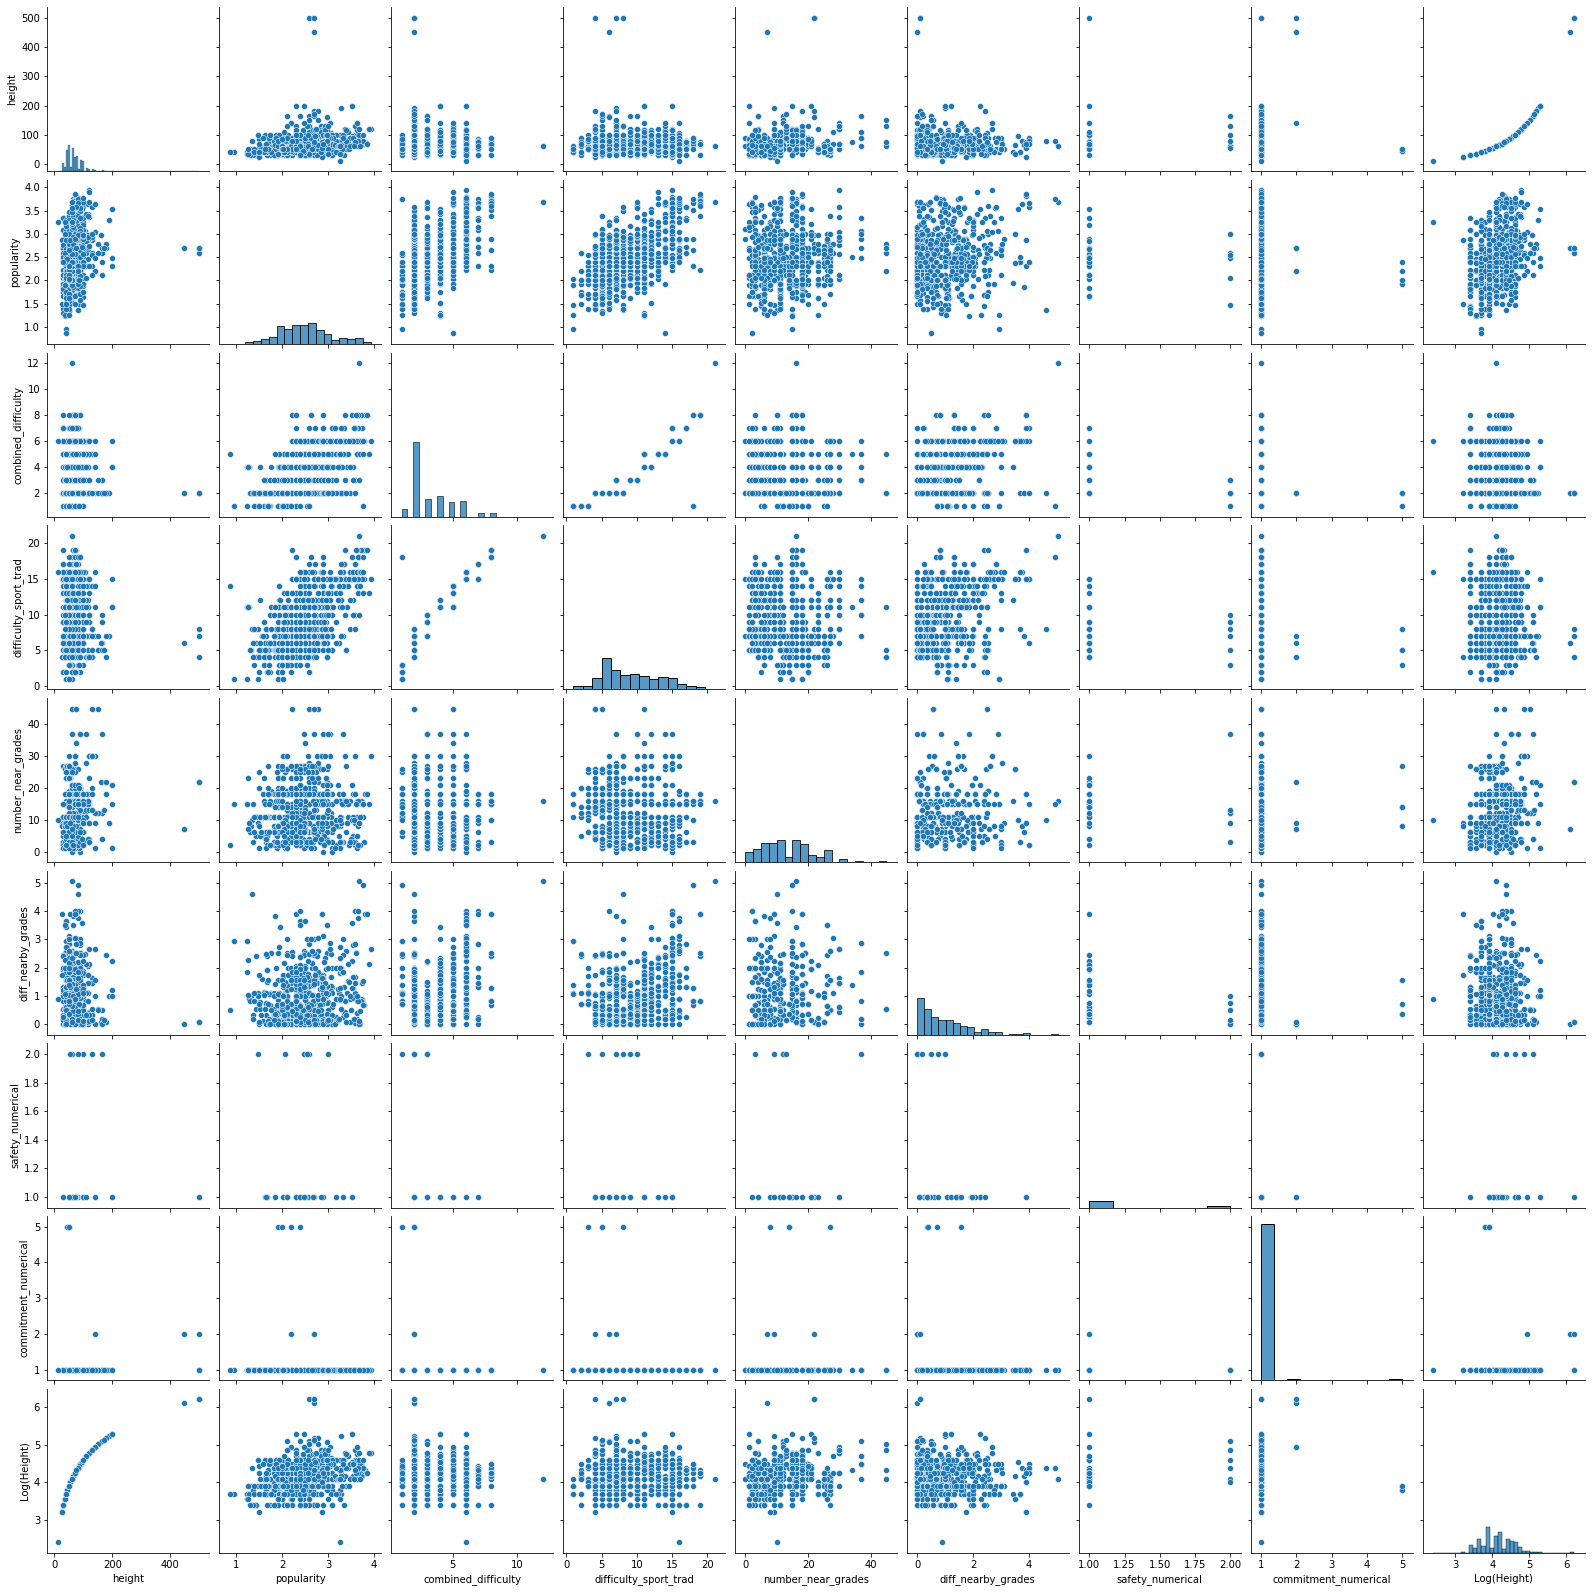

In [37]:
sns.pairplot(sport)

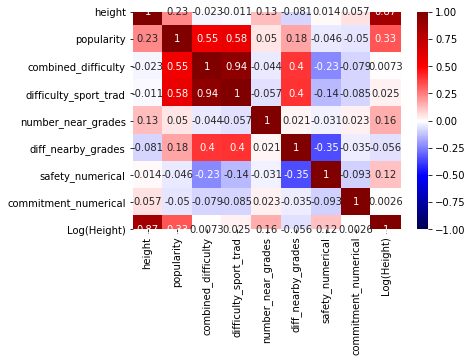

In [38]:
sns.heatmap(sport.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [39]:
X = sport[['difficulty_sport_trad', 'number_near_grades', 
          'Log(Height)', 'commitment_numerical']]
y = sport['popularity']

split_and_validate(X, y)


Train R^2 score was: 0.4604557739642001

Validation R^2 score was: 0.3352490091975857
Feature coefficient results: 

difficulty_sport_trad : 0.08
number_near_grades : 0.00
Log(Height) : 0.43
commitment_numerical : 0.01


## Just Boulders

In [40]:
boulder = pd.read_csv('boulder_routes.csv')

In [41]:
#Drop rows that have less than three votes
boulder = boulder[boulder['votes']>3]

In [42]:
boulder['Log(Height)'] = np.log(boulder['height'])

In [43]:
boulder.drop(columns = 'photos', inplace = True)
boulder.drop(columns = 'Unnamed: 0', inplace = True)
boulder.drop(columns = 'votes', inplace = True)
boulder.drop(columns = 'comments', inplace = True)
boulder.drop(columns = 'rating', inplace = True)
boulder.drop(columns = 'aid_grade', inplace = True)
boulder.drop(columns = 'pitches', inplace = True)
boulder.drop(columns = 'aid_numerical', inplace = True)
boulder.drop(columns = 'commitment', inplace = True)
boulder.drop(columns = 'commitment_numerical', inplace = True)

In [44]:
boulder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 921 entries, 0 to 1987
Data columns (total 15 columns):
name                     921 non-null object
grade                    921 non-null object
type                     921 non-null object
height                   921 non-null float64
safety                   59 non-null object
state                    921 non-null object
sub_area                 921 non-null object
near_grades              921 non-null object
popularity               921 non-null float64
combined_difficulty      921 non-null int64
difficulty_sport_trad    9 non-null float64
number_near_grades       921 non-null int64
diff_nearby_grades       859 non-null float64
safety_numerical         59 non-null float64
Log(Height)              921 non-null float64
dtypes: float64(6), int64(2), object(7)
memory usage: 115.1+ KB


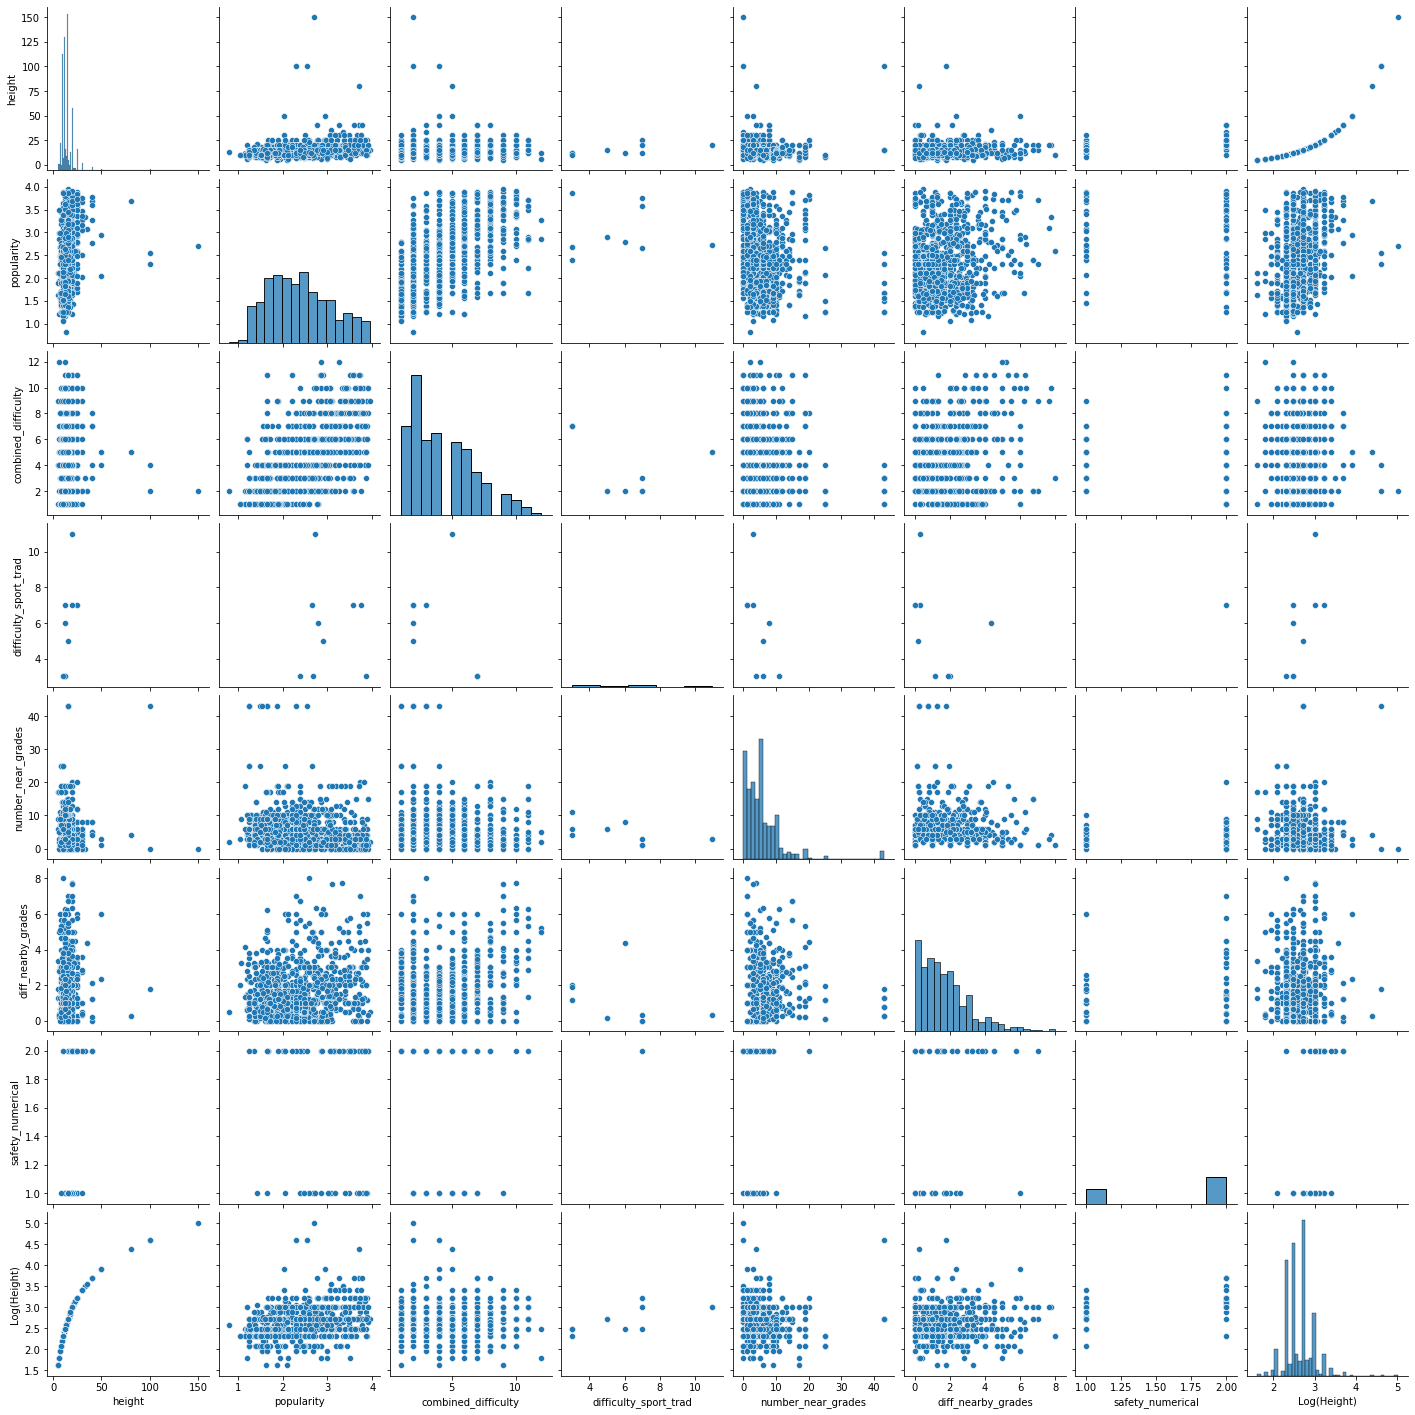

In [45]:
sns.pairplot(boulder)

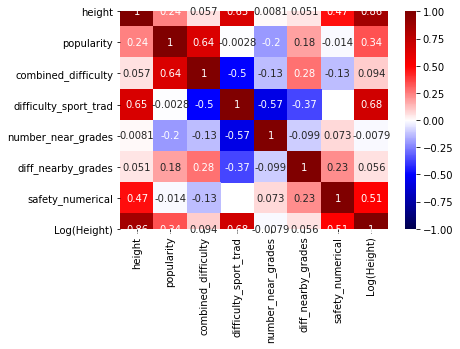

In [46]:
sns.heatmap(boulder.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [47]:
X = boulder[['combined_difficulty','Log(Height)', 'number_near_grades']]
y = boulder['popularity']

split_and_validate(X, y)


Train R^2 score was: 0.5108178851238678

Validation R^2 score was: 0.4604108684557102
Feature coefficient results: 

combined_difficulty : 0.17
Log(Height) : 0.57
number_near_grades : -0.01


## Just Trad

In [48]:
trad = pd.read_csv('trad_routes.csv')

In [49]:
#Drop rows that have less than three votes
trad = trad[trad['votes']>3]

In [50]:
trad['Log(Height)'] = np.log(trad['height'])

In [51]:
trad.drop(columns = 'photos', inplace = True)
trad.drop(columns = 'Unnamed: 0', inplace = True)
trad.drop(columns = 'votes', inplace = True)
trad.drop(columns = 'comments', inplace = True)
trad.drop(columns = 'rating', inplace = True)
trad.drop(columns = 'aid_grade', inplace = True)
trad.drop(columns = 'pitches', inplace = True)
trad.drop(columns = 'aid_numerical', inplace = True)
trad.drop(columns = 'commitment', inplace = True)

In [52]:
trad.head()

,name,grade,type,height,safety,state,sub_area,near_grades,popularity,combined_difficulty,difficulty_sport_trad,number_near_grades,diff_nearby_grades,safety_numerical,commitment_numerical,Log(Height)
3,Holey Gully,5.8+,['Trad'],70.0,NaN,California,p. Reed's Pinna…,"['5.11d', '5.10c', '5.10a', '5.12a', '5.10a', ...",3.032904,2,5.0,18,1.111111,NaN,1,4.248495
4,Alimony Cracks,5.8,['Trad'],100.0,NaN,California,Daff Dome,"['5.10c', '5.7', '5.10a', '5.10a', '5.8', '5.8...",2.498118,2,5.0,12,0.583333,NaN,1,4.605170
5,Hot Tub Honey,5.8,['Trad'],40.0,NaN,California,Hodgepodge Rock,"['5.4', '5.7', '5.9', '5.12a']",1.449714,2,5.0,4,0.750000,NaN,1,3.688879
8,Forces of Nature,5.10d,['Trad'],115.0,NaN,California,Patricia Bowl,"['5.12a', '5.10a', '5.10c', '5.10b', '5.11a', ...",2.849571,3,10.0,16,0.562500,NaN,1,4.744932
10,America's Cup,5.12b,['Trad'],200.0,PG13,California,h. Cookie Area,"['5.11b', '5.10b', '5.10a', '5.11c', '5.11a', ...",3.663169,6,16.0,34,2.411765,1.0,1,5.298317


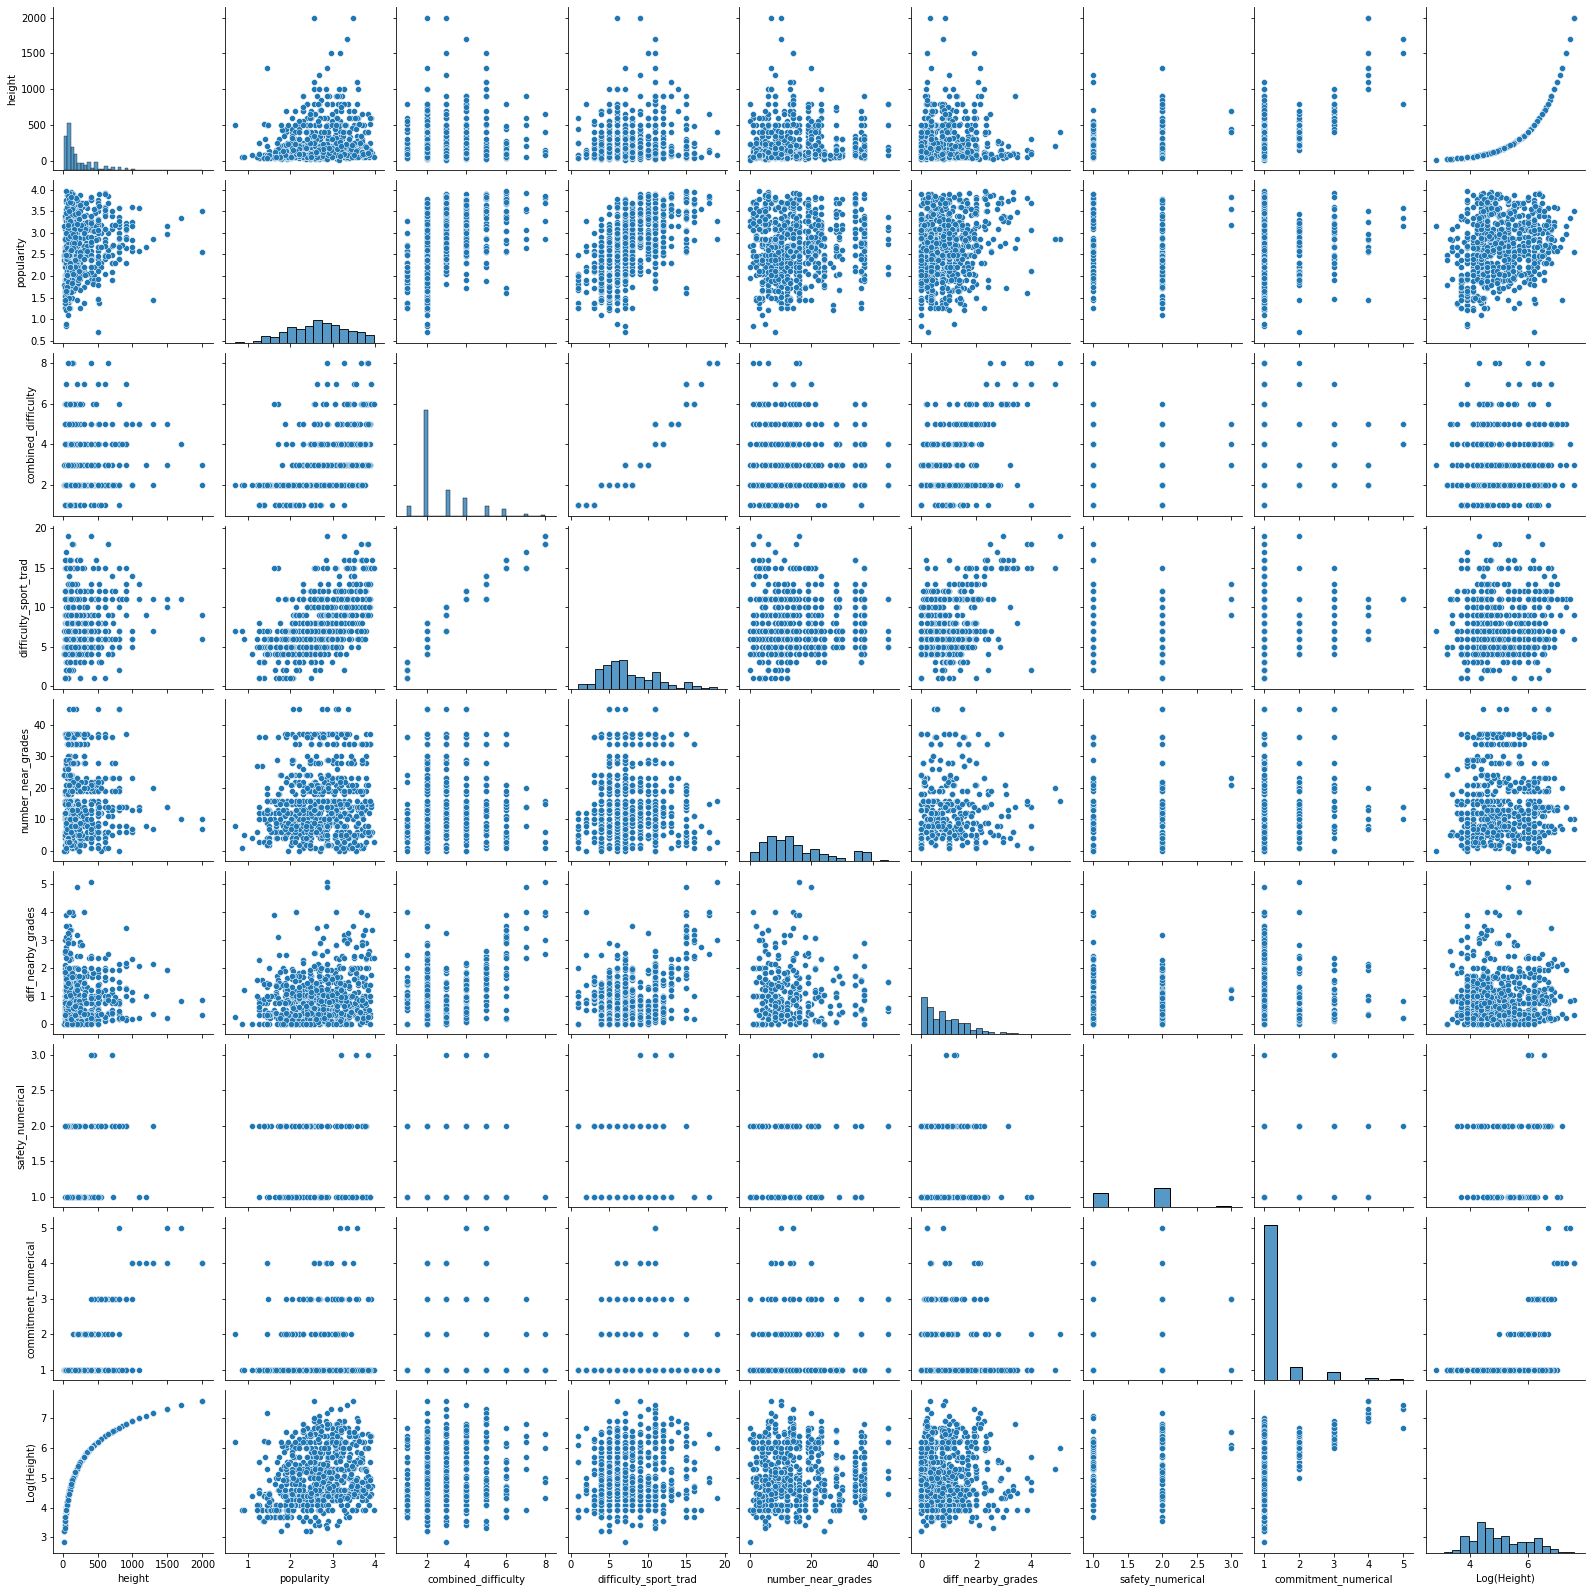

In [53]:
sns.pairplot(trad)

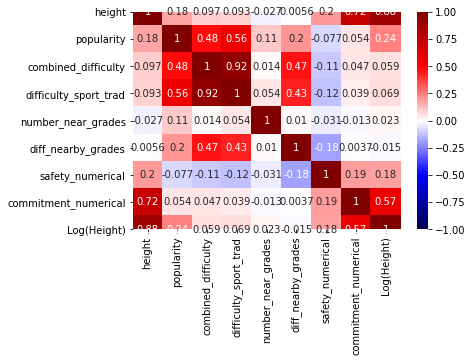

In [54]:
sns.heatmap(trad.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [55]:
X = trad[['Log(Height)', 'difficulty_sport_trad', 'number_near_grades', 'commitment_numerical']]
y = trad['popularity']

split_and_validate(X, y)


Train R^2 score was: 0.3779558174463349

Validation R^2 score was: 0.3688271457495427
Feature coefficient results: 

Log(Height) : 0.20
difficulty_sport_trad : 0.11
number_near_grades : 0.01
commitment_numerical : -0.13


# Final Model

In [56]:
import math

Prep the data.

In [57]:
#Read in the data
data_train = pd.read_csv('train_data.csv')
data_test = pd.read_csv('test_data.csv')

def model_format(df):
    #Drop features that don't support model
    df.drop(columns = 'photos', inplace = True)
    df.drop(columns = 'Unnamed: 0', inplace = True)
    df.drop(columns = 'comments', inplace = True)
    df.drop(columns = 'rating', inplace = True)
    df.drop(columns = 'name', inplace = True)

    #Drop rows that have less than three votes
    df = df[df['votes']>3]

    #Drop the votes column
    df.drop(columns = 'votes', inplace = True)

    #Convert height to log scale
    df['Log(Height)'] = np.log(df['height'])

    #Drop features that don't have enough data
    df.drop(columns = 'safety', inplace = True)
    df.drop(columns = 'commitment', inplace = True)
    df.drop(columns = 'aid_grade', inplace = True)
    df.drop(columns = 'aid_numerical', inplace = True)
    df.drop(columns = 'safety_numerical', inplace = True)

    #Drop features with collinearity
    df.drop(columns = 'pitches', inplace = True)

    #Add dummy variables from 'type' feature
    df = df.copy()
    train_category = df[['type']]

    def split_it(row):
        """Standardize type column by removing brackets, spaces, and quotation marks"""
        split_it = row['type'].replace('[', '').replace(']', '').replace("'", '').replace(' ', '')
        return split_it.split(',')

    df['type'] = df.apply(lambda row: split_it(row), axis=1)

    df = df.drop('type', 1).join(df.type.str.join('|').str.get_dummies())

    #Remove rows with wrong grades
    def remove_wrong_grade(row):
        if str(row['grade'])[0] == '5' and (row['Boulder'] == 1) and (row['Sport'] == 0) and (row['TR'] == 0) and (row['Trad'] == 0):
            df.drop(index = row.name, inplace = True)

    df.apply(lambda row: remove_wrong_grade(row), axis=1)
    
    return df
    
data_train = model_format(data_train)
data_test = model_format(data_test)

/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
X_train = data_train[['combined_difficulty', 
          'Log(Height)', 'Aid', 'Alpine', 'Boulder',
          'Sport', 'TR', 'Trad']]
X_test = data_test[['combined_difficulty', 
          'Log(Height)', 'Aid', 'Alpine', 'Boulder',
          'Sport', 'TR', 'Trad']]

y_train = data_train[['popularity']]
y_test = data_test[['popularity']]

In [60]:
final_model = LinearRegression()
final_model.fit(X_train, y_train)

print(f'Final R2 Score: {final_model.score(X_test, y_test)}')

rmse = math.sqrt(mean_squared_error(y_test, final_model.predict(X_test)))
print(f'Final RMSE Score: {rmse}')

Final R2 Score: 0.3939393208648867
Final RMSE Score: 0.5276153681394393


# Graphs

In [61]:
from sklearn.linear_model import LogisticRegression

yactual = y_test
print(yactual.iloc[0])

ynew = final_model.predict(X_test)

for i in range(len(ynew)):
    print("Actual: ", yactual.iloc[i]['popularity'], "Prediction: ", ynew[i])

popularity    2.299265
Name: 0, dtype: float64
Actual:  2.299264806362567 Prediction:  [2.28514384]
Actual:  2.396714176391811 Prediction:  [2.34858627]
Actual:  3.675348309553297 Prediction:  [2.84282993]
Actual:  2.911856705567246 Prediction:  [2.50215497]
Actual:  1.8989707289075943 Prediction:  [1.94165564]
Actual:  1.6589707289075946 Prediction:  [2.06665282]
Actual:  3.38894853644538 Prediction:  [2.67121478]
Actual:  3.88929902429692 Prediction:  [2.92399933]
Actual:  2.8589707289075954 Prediction:  [2.58275675]
Actual:  2.7924605021572826 Prediction:  [2.55921976]
Actual:  2.121650404948664 Prediction:  [1.92036427]
Actual:  2.89780744074108 Prediction:  [2.76536952]
Actual:  1.9438726271708853 Prediction:  [2.81997194]
Actual:  2.7867066748562626 Prediction:  [2.56953657]
Actual:  2.203513097945851 Prediction:  [2.06698064]
Actual:  2.2993567055672464 Prediction:  [2.31976518]
Actual:  2.299264806362567 Prediction:  [1.94165564]
Actual:  1.8549837382819967 Prediction:  [2.3441

Actual:  2.6786765076072614 Prediction:  [2.72633738]
Actual:  1.0989707289075945 Prediction:  [2.37154589]
Actual:  2.4933823756302567 Prediction:  [2.43054108]
Actual:  2.3868567055672467 Prediction:  [2.81612594]
Actual:  2.4589707289075946 Prediction:  [2.37154589]
Actual:  3.976641830747096 Prediction:  [2.98609684]
Actual:  2.382475607422996 Prediction:  [2.7262073]
Actual:  3.689817780032884 Prediction:  [2.79621197]
Actual:  2.1162378037114977 Prediction:  [2.30115112]
Actual:  3.844986694957997 Prediction:  [3.97851024]
Actual:  2.8852403327936087 Prediction:  [2.51781815]
Actual:  2.0327615160597743 Prediction:  [2.30115112]
Actual:  3.2497426822268984 Prediction:  [2.79653978]
Actual:  3.8956617666068594 Prediction:  [3.04697515]
Actual:  2.106089176391812 Prediction:  [1.79698597]
Actual:  3.2597941457815187 Prediction:  [2.79653978]
Actual:  1.83806566496446 Prediction:  [1.88900467]
Actual:  3.451794145781519 Prediction:  [2.43892748]
Actual:  2.2008864826592336 Predictio

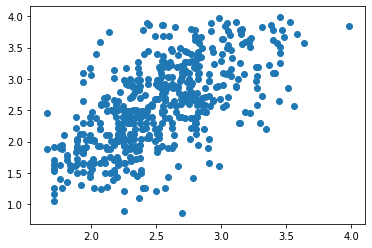

In [62]:
plt.scatter(x = final_model.predict(X_test), y = y_test)

## Height and Popularity

0.16777837967571713 1.8476156016630982


/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


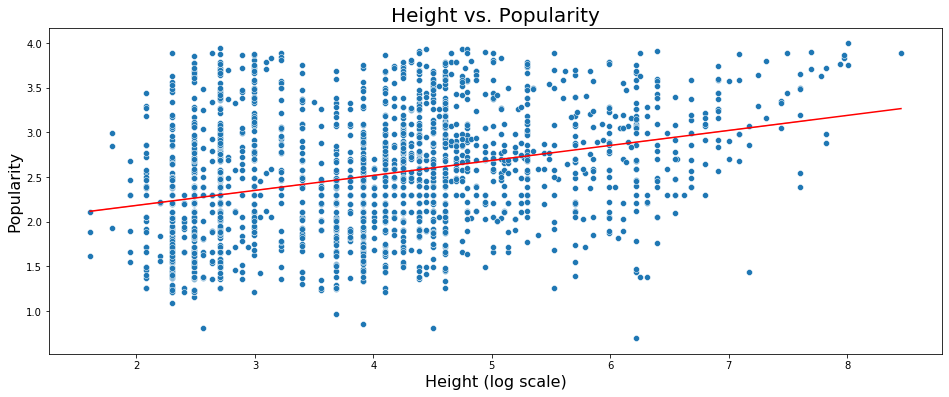

In [63]:
y_val = data_train['popularity']
x_val = data_train['Log(Height)']

m, b = np.polyfit(x_val, y_val, 1)
print(m, b)

plt.figure(figsize=(16, 6))
plt.title('Height vs. Popularity', fontsize = 20)


plt.xlabel('Height (log scale)', fontsize=16)
plt.ylabel('Popularity', fontsize=16)

sns.scatterplot(x_val,y_val);
sns.lineplot(x_val, m*x_val + b, color = 'red')


plt.show()

/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


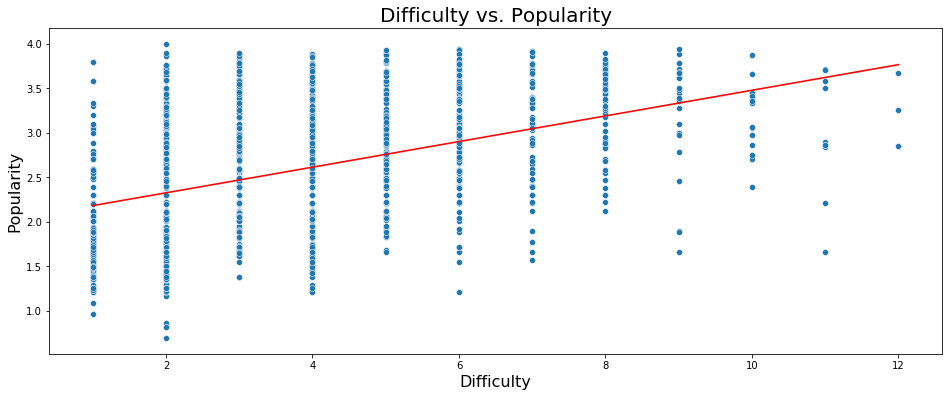

In [64]:
y_val = data_train['popularity']
x_val = data_train['combined_difficulty']

m, b = np.polyfit(x_val, y_val, 1)

plt.figure(figsize=(16, 6))
plt.title('Difficulty vs. Popularity', fontsize = 20)
plt.xlabel('Difficulty', fontsize=16)
plt.ylabel('Popularity', fontsize=16)

sns.lineplot(x_val, m*x_val + b, color = 'red')
sns.scatterplot(x_val,y_val);

plt.show()

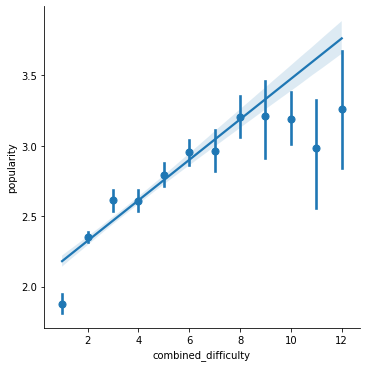

In [65]:

sns.lmplot(x="combined_difficulty", y="popularity", data=data_train, x_estimator=np.mean);




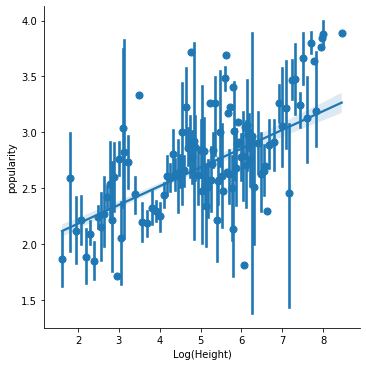

In [66]:
sns.lmplot(x="Log(Height)", y="popularity", data=data_train, x_estimator=np.mean);
